In [1]:
from google.colab import drive

drive.mount('/content/drive')

%cd drive/MyDrive/Colab Notebooks
#! ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('data_model.csv')
df.shape

(8712, 26)

In [3]:
df_trainA = df.sample(frac=0.7, random_state=44)
df_val_testA = df.drop(df_trainA.index).reset_index(drop=True)
df_valA = df_val_testA.sample(frac=0.5, random_state=44)
df_testA = df_val_testA.drop(df_valA.index).reset_index(drop=True)
df_trainA = df_trainA.reset_index(drop=True)
df_valA = df_valA.reset_index(drop=True)

print(df_trainA.shape, df_valA.shape, df_testA.shape)

(6098, 26) (1307, 26) (1307, 26)


In [4]:
df_train = df_trainA[['label', 'comment_text']]
df_val = df_valA[['label', 'comment_text']]
df_test = df_testA[['label', 'comment_text']]
df_train.head()

,label,comment_text
0,0,What would the expression be for the number of...
1,0,"So after i subtracted 11 from both sides, i go..."
2,0,you have to plug 3 in for x then solve the pro...
3,1,ok that was like a brain fart i should have kn...
4,0,"Well, since you are solving for x go ahead and..."


In [2]:
!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00


In [6]:
#!pip install transformers

In [7]:
!pip install utils

# Load ELECTRA model and tokenizer


In [8]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from utils import *
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')

# Load Electra Model
model = AutoModelForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=2)

model.to(device)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.o

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

# Load Dataset

In [10]:
X_train_tokenized = tokenizer(list(df_train["comment_text"]), padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(list(df_val["comment_text"]), padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(list(df_test["comment_text"]), padding=True, truncation=True, max_length=512)

In [11]:
y_train = list(df_train["label"])
y_val = list(df_val["label"])
y_test = list(df_test["label"])

In [12]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [13]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized, y_test)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Fine-tuning

In [15]:
# Define the optimizer and learning rate scheduler
num_epochs = 5
#optimizer = optim.AdamW(model.parameters(), lr=6.68561343998775e-5, eps=1e-8)
#total_steps = len(train_loader) * num_epochs
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [16]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [17]:
from transformers import TrainingArguments, Trainer

In [18]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=20,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=num_epochs,
    seed=0,
    logging_steps=20,
    optim="adamw_torch",
    load_best_model_at_end=True,
)

In [19]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,

)

In [17]:
import time

In [20]:
# Training Electra model
# train_loss = []
# val_losses = []
# val_accuracies = []

#start = time.time()
# trainer(train_loss, val_losses, val_accuracies, num_epochs, train_loader, val_dataset, val_loader, model, optimizer, scheduler, device)
# Train pre-trained model
trainer.train()
#print("Time",time.time()-start)

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,0.529200,0.352653,0.879878,0.905738,0.799277,0.849183
40,0.451000,0.278164,0.899005,0.863558,0.904159,0.883392
60,0.235800,0.213078,0.931140,0.921676,0.915009,0.918330
80,0.207700,0.213207,0.937261,0.950287,0.898734,0.923792
100,0.216500,0.247464,0.930375,0.906690,0.931284,0.918822
120,0.274300,0.346771,0.866871,0.994778,0.688969,0.814103
140,0.282100,0.163287,0.951798,0.958801,0.925859,0.942042
160,0.178700,0.183456,0.950268,0.976562,0.904159,0.938967
180,0.183000,0.159584,0.955624,0.960894,0.933092,0.946789
200,0.117300,0.166604,0.958684,0.966355,0.934901,0.950368


TrainOutput(global_step=3050, training_loss=0.06817850284889096, metrics={'train_runtime': 8913.465, 'train_samples_per_second': 3.421, 'train_steps_per_second': 0.342, 'total_flos': 8022256077926400.0, 'train_loss': 0.06817850284889096, 'epoch': 5.0})

In [22]:
# save the model
torch.save(model.state_dict(), 'transformerELECTRA-1.pt')

#### Test model on test set

In [23]:
# Load trained model
model_path = "output/checkpoint-2500"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
#model.to(device)

In [24]:
# Define test trainer
test_trainer = Trainer(model)

In [ ]:
# Metrics for training dataset
raw_pred_train, _, _ = test_trainer.predict(train_dataset)
p_train = raw_pred_train, y_train
metrics_train = compute_metrics(p_train)
metrics_train

In [25]:
# Metrics for validation dataset
raw_pred_val, _, _ = test_trainer.predict(val_dataset)
p_val = raw_pred_val, y_val
metrics_val = compute_metrics(p_val)
metrics_val

{'accuracy': 0.9701606732976281,
 'precision': 0.9672727272727273,
 'recall': 0.9620253164556962,
 'f1': 0.9646418857660926}

In [26]:
# Metrics for test dataset
# Make prediction
raw_pred_test, _, _ = test_trainer.predict(test_dataset)

p_test = raw_pred_test, y_test
metrics_test = compute_metrics(p_test)
metrics_test

{'accuracy': 0.9778117827084928,
 'precision': 0.9712746858168761,
 'recall': 0.9765342960288809,
 'f1': 0.973897389738974}

**SHAP**

In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.3 MB/s eta 0:00:00


In [4]:
from transformers import ZeroShotClassificationPipeline
from typing import Union, List
import shap

In [5]:
# Load trained model
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_path = "output/checkpoint-2500"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
#model.to(device)

In [6]:
# Create a custom pipeline that only requires the text parameter
# for the __call__ method and provides a method to set the labels
class ZeroShotModelPipeline(ZeroShotClassificationPipeline):
  def _parse_labels(self, labels):
        if isinstance(labels, str):
            labels = [label.strip() for label in labels.split(",")]
        return labels

    # Overwrite the __call__ method
  def __call__(self, *args):
        out = super().__call__(args[0], self.set_labels)[0]

        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]

  def set_labels(self, labels: Union[str,List[str]]):
        self.set_labels = labels

In [7]:
def score_and_visualize(text, shap_values):
    prediction = pipe(text)
    print(f"Model predictions are: {prediction}")
    shap.plots.text(shap_values)

In [8]:
# Setting up the inference text data and the corresponding labels
text = ["tyler shut up before i smack u in your head"]
labels = ["safe","unsafe"]

In [9]:
text2 =["can someone kill me please. i hate life and i cant hang myself:("]
labels = ["safe", "unsafe"]

In [11]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')

In [12]:
# Assign the labels for the classification model
model.config.label2id.update({v:k for k,v in enumerate(labels)})
model.config.id2label.update({k:v for k,v in enumerate(labels)})

pipe = ZeroShotModelPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

# Setting the on-the-fly labels to the model pipeline
pipe.set_labels(labels)

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


SHAP for explainability

In [13]:
# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values = explainer(text)
score_and_visualize(text, shap_values)

  0%|          | 0/132 [00:00<?, ?it/s]

Partition explainer: 2it [00:35, 35.95s/it]               


Model predictions are: [[{'label': 'unsafe', 'score': 0.5033205151557922}, {'label': 'safe', 'score': 0.49667948484420776}]]


In [14]:
# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values2 = explainer(text2)

score_and_visualize(text2, shap_values2)

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer: 2it [02:25, 145.13s/it]              


Model predictions are: [[{'label': 'unsafe', 'score': 0.5041057467460632}, {'label': 'safe', 'score': 0.49589431285858154}]]


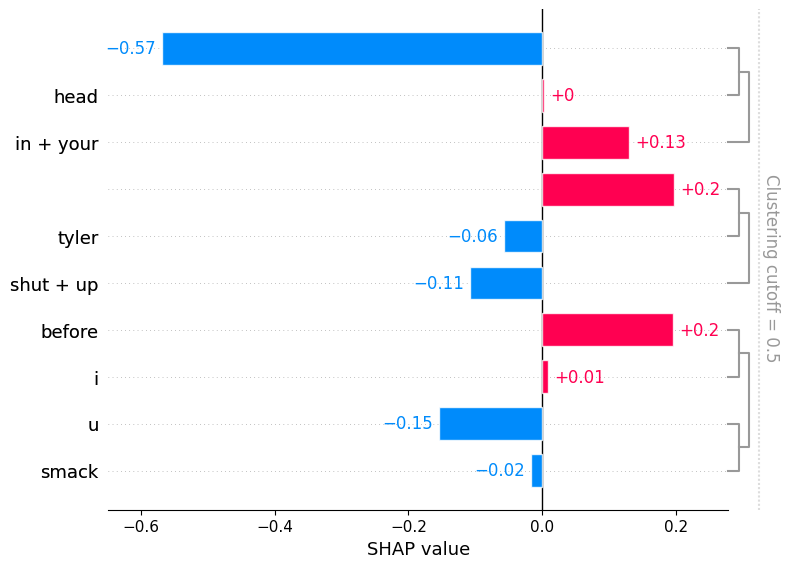

In [15]:
# Let's visualize the feature importance towards the outcome - unsafe
shap.plots.bar(shap_values[0,:,'unsafe'])

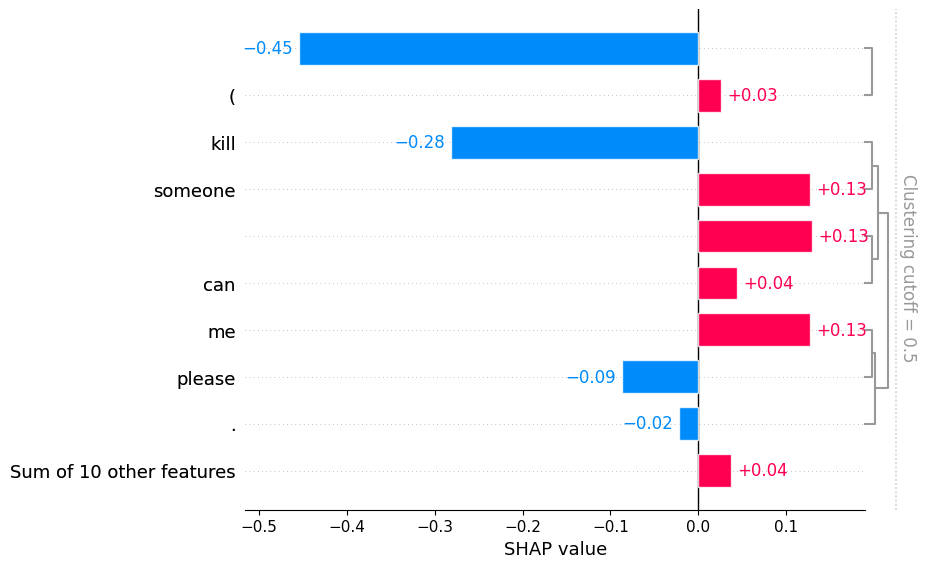

In [16]:
# Let's visualize the feature importance towards the outcome - unsafe
shap.plots.bar(shap_values2[0,:,'unsafe'])